In [1]:
!pip install -q gradio albumentations timm segmentation-models-pytorch scikit-learn pandas
# Install SAM and its dependencies
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'
!pip install -q opencv-python pycocotools

!pip install -q torch torchvision torchaudio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
from google.colab import drive
import zipfile, os

# --- DRIVE MOUNT ---
drive.mount('/content/drive')

# --- PATH CONFIGURATION (Corrected per User Request) ---
ZIP_PATH = "/content/drive/MyDrive/HAM10000_metadata/HAM10000.zip"
EXTRACT_PATH = "/content/HAM10000_data"
METADATA_FILE = "HAM10000_metadata.csv"

# --- UNZIP DATASET ---
if not os.path.exists(EXTRACT_PATH):
    print("Extracting dataset...")
    # Create the extraction directory
    os.makedirs(EXTRACT_PATH, exist_ok=True)

    try:
        with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
            zip_ref.extractall(EXTRACT_PATH)
        print("Dataset extracted to:", EXTRACT_PATH)
    except FileNotFoundError:
        raise FileNotFoundError(f"Error: ZIP file not found at the specified path: {ZIP_PATH}. Please check your Google Drive path.")
else:
    print("Dataset already extracted.")

# --- FIND METADATA FILE ---
FINAL_METADATA_PATH = os.path.join(EXTRACT_PATH, METADATA_FILE)
if not os.path.exists(FINAL_METADATA_PATH):
    # Search one level deeper in case the zip created a root folder
    potential_dirs = [d for d in os.listdir(EXTRACT_PATH) if os.path.isdir(os.path.join(EXTRACT_PATH, d))]
    for d in potential_dirs:
        if os.path.exists(os.path.join(EXTRACT_PATH, d, METADATA_FILE)):
            FINAL_METADATA_PATH = os.path.join(EXTRACT_PATH, d, METADATA_FILE)
            break

if not os.path.exists(FINAL_METADATA_PATH):
    raise FileNotFoundError(f"Metadata file '{METADATA_FILE}' not found in the extracted path: {EXTRACT_PATH}")

print(f"Metadata file path: {FINAL_METADATA_PATH}")


# --- GET IMAGE FOLDERS ---
# This looks for the image files, typically in one or two subfolders (part1, part2)
IMAGE_DIRS = []
for root, dirs, files in os.walk(EXTRACT_PATH):
    # Check if a directory contains a large number of .jpg files
    if any(f.endswith('.jpg') for f in files) and len(files) > 50:
        IMAGE_DIRS.append(root)

if not IMAGE_DIRS:
    print("Warning: Standard image folders (part1/part2) not found. Assuming images are flat in EXTRACT_PATH.")
    IMAGE_DIRS = [EXTRACT_PATH] # Fallback

print("Image directories found:", IMAGE_DIRS)

Mounted at /content/drive
Extracting dataset...
Dataset extracted to: /content/HAM10000_data
Metadata file path: /content/HAM10000_data/HAM10000_metadata.csv
Image directories found: ['/content/HAM10000_data/ham10000_images_part_1', '/content/HAM10000_data/HAM10000_images_part_1', '/content/HAM10000_data/ham10000_images_part_2', '/content/HAM10000_data/HAM10000_images_part_2']


In [3]:
import pandas as pd
import os

# Load the metadata
df = pd.read_csv(FINAL_METADATA_PATH)

# Get the classes and mapping
classes = sorted(df['dx'].unique().tolist())
num_classes = len(classes)

class_to_idx = {cls: i for i, cls in enumerate(classes)}
idx_to_class = {i: cls for cls, i in class_to_idx.items()}

print("Classes:", classes)
print("Number of Classes:", num_classes)
print("Total Samples:", len(df))

Classes: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
Number of Classes: 7
Total Samples: 10015


In [4]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

IMG_SIZE = 224

train_tfms = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.Rotate(limit=20, p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

val_tfms = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

In [5]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
import numpy as np
from sklearn.model_selection import train_test_split

class HAMDataset(Dataset):
    def __init__(self, img_ids, labels, transform, image_dirs):
        self.img_ids = img_ids
        self.labels = labels
        self.tfms = transform

        # Pre-map image ID to full path for faster loading
        self.id_to_path = {}
        for img_dir in image_dirs:
            for filename in os.listdir(img_dir):
                img_id = filename.split('.')[0]
                self.id_to_path[img_id] = os.path.join(img_dir, filename)

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        label = self.labels[idx]

        img_path = self.id_to_path.get(img_id)
        if not img_path:
             raise FileNotFoundError(f"Image ID {img_id} not found in any image directory.")

        img = Image.open(img_path).convert("RGB")
        img = self.tfms(image=np.array(img))["image"]

        return img, label

# --- Prepare data for split ---
image_ids = df['image_id'].tolist()
labels = df['dx'].map(class_to_idx).tolist()

# Stratified split
X_train_ids, X_val_ids, y_train, y_val = train_test_split(
    image_ids, labels, test_size=0.2, stratify=labels, random_state=42
)

# --- Create DataLoaders ---
train_loader = DataLoader(
    HAMDataset(X_train_ids, y_train, train_tfms, IMAGE_DIRS),
    batch_size=32, shuffle=True, num_workers=2
)

val_loader = DataLoader(
    HAMDataset(X_val_ids, y_val, val_tfms, IMAGE_DIRS),
    batch_size=32, shuffle=False, num_workers=2
)

print(f"Train samples: {len(X_train_ids)}, Validation samples: {len(X_val_ids)}")

Train samples: 8012, Validation samples: 2003


In [6]:
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

def train_model(model, epochs=20):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    history = {"train_acc": [], "val_acc": []}
    best_val_acc = 0.0
    best_weights = None

    print(f"Starting training on device: {device}")

    for epoch in range(epochs):
        model.train()
        correct = total = 0

        for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1} Train"):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

            correct += (out.argmax(1) == y).sum().item()
            total += y.size(0)

        train_acc = correct / total

        model.eval()
        correct = total = 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                correct += (out.argmax(1) == y).sum().item()
                total += y.size(0)

        val_acc = correct / total

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_weights = model.state_dict()

        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} (Best: {best_val_acc:.4f})")

    if best_weights:
        model.load_state_dict(best_weights)

    return history

# --- The following cells (7-12) remain the same ---

In [7]:
from torchvision.models import mobilenet_v3_large
model_mobilenet = mobilenet_v3_large(pretrained=True)
model_mobilenet.classifier[3] = nn.Linear(1280, num_classes)
hist_mobilenet = train_model(model_mobilenet)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth


100%|██████████| 21.1M/21.1M [00:00<00:00, 78.2MB/s]


Starting training on device: cuda


Epoch 1 Train: 100%|██████████| 251/251 [01:12<00:00,  3.48it/s]


Epoch 1/20 | Train Acc: 0.7312 | Val Acc: 0.7813 (Best: 0.7813)


Epoch 2 Train: 100%|██████████| 251/251 [00:58<00:00,  4.31it/s]


Epoch 2/20 | Train Acc: 0.8117 | Val Acc: 0.8183 (Best: 0.8183)


Epoch 3 Train: 100%|██████████| 251/251 [00:58<00:00,  4.26it/s]


Epoch 3/20 | Train Acc: 0.8469 | Val Acc: 0.8392 (Best: 0.8392)


Epoch 4 Train: 100%|██████████| 251/251 [00:59<00:00,  4.21it/s]


Epoch 4/20 | Train Acc: 0.8712 | Val Acc: 0.8527 (Best: 0.8527)


Epoch 5 Train: 100%|██████████| 251/251 [01:01<00:00,  4.08it/s]


Epoch 5/20 | Train Acc: 0.9000 | Val Acc: 0.8537 (Best: 0.8537)


Epoch 6 Train: 100%|██████████| 251/251 [00:59<00:00,  4.19it/s]


Epoch 6/20 | Train Acc: 0.9055 | Val Acc: 0.8682 (Best: 0.8682)


Epoch 7 Train: 100%|██████████| 251/251 [00:59<00:00,  4.21it/s]


Epoch 7/20 | Train Acc: 0.9277 | Val Acc: 0.8607 (Best: 0.8682)


Epoch 8 Train: 100%|██████████| 251/251 [00:59<00:00,  4.24it/s]


Epoch 8/20 | Train Acc: 0.9362 | Val Acc: 0.8707 (Best: 0.8707)


Epoch 9 Train: 100%|██████████| 251/251 [00:59<00:00,  4.25it/s]


Epoch 9/20 | Train Acc: 0.9433 | Val Acc: 0.8717 (Best: 0.8717)


Epoch 10 Train: 100%|██████████| 251/251 [00:59<00:00,  4.21it/s]


Epoch 10/20 | Train Acc: 0.9514 | Val Acc: 0.8767 (Best: 0.8767)


Epoch 11 Train: 100%|██████████| 251/251 [01:00<00:00,  4.18it/s]


Epoch 11/20 | Train Acc: 0.9538 | Val Acc: 0.8727 (Best: 0.8767)


Epoch 12 Train: 100%|██████████| 251/251 [00:59<00:00,  4.20it/s]


Epoch 12/20 | Train Acc: 0.9644 | Val Acc: 0.8737 (Best: 0.8767)


Epoch 13 Train: 100%|██████████| 251/251 [00:59<00:00,  4.23it/s]


Epoch 13/20 | Train Acc: 0.9692 | Val Acc: 0.8807 (Best: 0.8807)


Epoch 14 Train: 100%|██████████| 251/251 [00:59<00:00,  4.21it/s]


Epoch 14/20 | Train Acc: 0.9695 | Val Acc: 0.8812 (Best: 0.8812)


Epoch 15 Train: 100%|██████████| 251/251 [00:59<00:00,  4.22it/s]


Epoch 15/20 | Train Acc: 0.9727 | Val Acc: 0.8762 (Best: 0.8812)


Epoch 16 Train: 100%|██████████| 251/251 [01:00<00:00,  4.17it/s]


Epoch 16/20 | Train Acc: 0.9755 | Val Acc: 0.8742 (Best: 0.8812)


Epoch 17 Train: 100%|██████████| 251/251 [00:59<00:00,  4.19it/s]


Epoch 17/20 | Train Acc: 0.9772 | Val Acc: 0.8882 (Best: 0.8882)


Epoch 18 Train: 100%|██████████| 251/251 [01:01<00:00,  4.09it/s]


Epoch 18/20 | Train Acc: 0.9819 | Val Acc: 0.8767 (Best: 0.8882)


Epoch 19 Train: 100%|██████████| 251/251 [01:00<00:00,  4.14it/s]


Epoch 19/20 | Train Acc: 0.9793 | Val Acc: 0.8712 (Best: 0.8882)


Epoch 20 Train: 100%|██████████| 251/251 [01:00<00:00,  4.17it/s]


Epoch 20/20 | Train Acc: 0.9833 | Val Acc: 0.8832 (Best: 0.8882)


In [8]:
from torchvision.models import efficientnet_b0
model_eff = efficientnet_b0(pretrained=True)
model_eff.classifier[1] = nn.Linear(1280, num_classes)
hist_eff = train_model(model_eff)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 203MB/s]


Starting training on device: cuda


Epoch 1 Train: 100%|██████████| 251/251 [01:05<00:00,  3.86it/s]


Epoch 1/20 | Train Acc: 0.7205 | Val Acc: 0.8073 (Best: 0.8073)


Epoch 2 Train: 100%|██████████| 251/251 [01:04<00:00,  3.91it/s]


Epoch 2/20 | Train Acc: 0.8112 | Val Acc: 0.8407 (Best: 0.8407)


Epoch 3 Train: 100%|██████████| 251/251 [01:03<00:00,  3.95it/s]


Epoch 3/20 | Train Acc: 0.8399 | Val Acc: 0.8522 (Best: 0.8522)


Epoch 4 Train: 100%|██████████| 251/251 [01:05<00:00,  3.84it/s]


Epoch 4/20 | Train Acc: 0.8696 | Val Acc: 0.8697 (Best: 0.8697)


Epoch 5 Train: 100%|██████████| 251/251 [01:04<00:00,  3.88it/s]


Epoch 5/20 | Train Acc: 0.8902 | Val Acc: 0.8472 (Best: 0.8697)


Epoch 6 Train: 100%|██████████| 251/251 [01:03<00:00,  3.95it/s]


Epoch 6/20 | Train Acc: 0.9069 | Val Acc: 0.8732 (Best: 0.8732)


Epoch 7 Train: 100%|██████████| 251/251 [01:04<00:00,  3.89it/s]


Epoch 7/20 | Train Acc: 0.9111 | Val Acc: 0.8747 (Best: 0.8747)


Epoch 8 Train: 100%|██████████| 251/251 [01:04<00:00,  3.90it/s]


Epoch 8/20 | Train Acc: 0.9280 | Val Acc: 0.8862 (Best: 0.8862)


Epoch 9 Train: 100%|██████████| 251/251 [01:02<00:00,  4.02it/s]


Epoch 9/20 | Train Acc: 0.9363 | Val Acc: 0.8777 (Best: 0.8862)


Epoch 10 Train: 100%|██████████| 251/251 [01:02<00:00,  4.03it/s]


Epoch 10/20 | Train Acc: 0.9461 | Val Acc: 0.8887 (Best: 0.8887)


Epoch 11 Train: 100%|██████████| 251/251 [01:03<00:00,  3.96it/s]


Epoch 11/20 | Train Acc: 0.9562 | Val Acc: 0.8787 (Best: 0.8887)


Epoch 12 Train: 100%|██████████| 251/251 [01:04<00:00,  3.92it/s]


Epoch 12/20 | Train Acc: 0.9553 | Val Acc: 0.8882 (Best: 0.8887)


Epoch 13 Train: 100%|██████████| 251/251 [01:03<00:00,  3.97it/s]


Epoch 13/20 | Train Acc: 0.9608 | Val Acc: 0.8862 (Best: 0.8887)


Epoch 14 Train: 100%|██████████| 251/251 [01:03<00:00,  3.97it/s]


Epoch 14/20 | Train Acc: 0.9710 | Val Acc: 0.8812 (Best: 0.8887)


Epoch 15 Train: 100%|██████████| 251/251 [01:03<00:00,  3.93it/s]


Epoch 15/20 | Train Acc: 0.9651 | Val Acc: 0.8947 (Best: 0.8947)


Epoch 16 Train: 100%|██████████| 251/251 [01:02<00:00,  4.00it/s]


Epoch 16/20 | Train Acc: 0.9720 | Val Acc: 0.8907 (Best: 0.8947)


Epoch 17 Train: 100%|██████████| 251/251 [01:02<00:00,  4.00it/s]


Epoch 17/20 | Train Acc: 0.9729 | Val Acc: 0.8997 (Best: 0.8997)


Epoch 18 Train: 100%|██████████| 251/251 [01:04<00:00,  3.89it/s]


Epoch 18/20 | Train Acc: 0.9697 | Val Acc: 0.8937 (Best: 0.8997)


Epoch 19 Train: 100%|██████████| 251/251 [01:05<00:00,  3.85it/s]


Epoch 19/20 | Train Acc: 0.9770 | Val Acc: 0.8922 (Best: 0.8997)


Epoch 20 Train: 100%|██████████| 251/251 [01:04<00:00,  3.90it/s]


Epoch 20/20 | Train Acc: 0.9769 | Val Acc: 0.8852 (Best: 0.8997)


In [9]:
import timm
model_xcep = timm.create_model("xception", pretrained=True, num_classes=num_classes)
hist_xcep = train_model(model_xcep)

/usr/local/lib/python3.12/dist-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth
Starting training on device: cuda


Epoch 1 Train: 100%|██████████| 251/251 [02:02<00:00,  2.05it/s]


Epoch 1/20 | Train Acc: 0.7385 | Val Acc: 0.8068 (Best: 0.8068)


Epoch 2 Train: 100%|██████████| 251/251 [02:01<00:00,  2.07it/s]


Epoch 2/20 | Train Acc: 0.8339 | Val Acc: 0.8258 (Best: 0.8258)


Epoch 3 Train: 100%|██████████| 251/251 [02:02<00:00,  2.04it/s]


Epoch 3/20 | Train Acc: 0.8704 | Val Acc: 0.8467 (Best: 0.8467)


Epoch 4 Train: 100%|██████████| 251/251 [02:01<00:00,  2.07it/s]


Epoch 4/20 | Train Acc: 0.9043 | Val Acc: 0.8577 (Best: 0.8577)


Epoch 5 Train: 100%|██████████| 251/251 [02:00<00:00,  2.08it/s]


Epoch 5/20 | Train Acc: 0.9239 | Val Acc: 0.8657 (Best: 0.8657)


Epoch 6 Train: 100%|██████████| 251/251 [02:01<00:00,  2.07it/s]


Epoch 6/20 | Train Acc: 0.9376 | Val Acc: 0.8732 (Best: 0.8732)


Epoch 7 Train: 100%|██████████| 251/251 [02:01<00:00,  2.07it/s]


Epoch 7/20 | Train Acc: 0.9524 | Val Acc: 0.8772 (Best: 0.8772)


Epoch 8 Train: 100%|██████████| 251/251 [02:01<00:00,  2.07it/s]


Epoch 8/20 | Train Acc: 0.9571 | Val Acc: 0.8737 (Best: 0.8772)


Epoch 9 Train: 100%|██████████| 251/251 [02:01<00:00,  2.07it/s]


Epoch 9/20 | Train Acc: 0.9622 | Val Acc: 0.8852 (Best: 0.8852)


Epoch 10 Train: 100%|██████████| 251/251 [02:01<00:00,  2.07it/s]


Epoch 10/20 | Train Acc: 0.9739 | Val Acc: 0.8722 (Best: 0.8852)


Epoch 11 Train: 100%|██████████| 251/251 [02:01<00:00,  2.07it/s]


Epoch 11/20 | Train Acc: 0.9709 | Val Acc: 0.8962 (Best: 0.8962)


Epoch 12 Train: 100%|██████████| 251/251 [02:01<00:00,  2.07it/s]


Epoch 12/20 | Train Acc: 0.9709 | Val Acc: 0.9016 (Best: 0.9016)


Epoch 13 Train: 100%|██████████| 251/251 [02:01<00:00,  2.07it/s]


Epoch 13/20 | Train Acc: 0.9773 | Val Acc: 0.8937 (Best: 0.9016)


Epoch 14 Train: 100%|██████████| 251/251 [02:01<00:00,  2.07it/s]


Epoch 14/20 | Train Acc: 0.9794 | Val Acc: 0.8982 (Best: 0.9016)


Epoch 15 Train: 100%|██████████| 251/251 [02:00<00:00,  2.08it/s]


Epoch 15/20 | Train Acc: 0.9832 | Val Acc: 0.8947 (Best: 0.9016)


Epoch 16 Train: 100%|██████████| 251/251 [02:00<00:00,  2.08it/s]


Epoch 16/20 | Train Acc: 0.9828 | Val Acc: 0.8852 (Best: 0.9016)


Epoch 17 Train: 100%|██████████| 251/251 [02:01<00:00,  2.07it/s]


Epoch 17/20 | Train Acc: 0.9814 | Val Acc: 0.8942 (Best: 0.9016)


Epoch 18 Train: 100%|██████████| 251/251 [02:01<00:00,  2.07it/s]


Epoch 18/20 | Train Acc: 0.9828 | Val Acc: 0.8962 (Best: 0.9016)


Epoch 19 Train: 100%|██████████| 251/251 [02:01<00:00,  2.07it/s]


Epoch 19/20 | Train Acc: 0.9827 | Val Acc: 0.8982 (Best: 0.9016)


Epoch 20 Train: 100%|██████████| 251/251 [02:01<00:00,  2.07it/s]


Epoch 20/20 | Train Acc: 0.9858 | Val Acc: 0.8897 (Best: 0.9016)


In [10]:
from torchvision.models import resnet50
model_res = resnet50(pretrained=True)
model_res.fc = nn.Linear(2048, num_classes)
hist_res = train_model(model_res)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 198MB/s]


Starting training on device: cuda


Epoch 1 Train: 100%|██████████| 251/251 [01:21<00:00,  3.08it/s]


Epoch 1/20 | Train Acc: 0.7672 | Val Acc: 0.8143 (Best: 0.8143)


Epoch 2 Train: 100%|██████████| 251/251 [01:22<00:00,  3.03it/s]


Epoch 2/20 | Train Acc: 0.8231 | Val Acc: 0.8427 (Best: 0.8427)


Epoch 3 Train: 100%|██████████| 251/251 [01:22<00:00,  3.05it/s]


Epoch 3/20 | Train Acc: 0.8455 | Val Acc: 0.8532 (Best: 0.8532)


Epoch 4 Train: 100%|██████████| 251/251 [01:22<00:00,  3.04it/s]


Epoch 4/20 | Train Acc: 0.8663 | Val Acc: 0.8612 (Best: 0.8612)


Epoch 5 Train: 100%|██████████| 251/251 [01:23<00:00,  3.00it/s]


Epoch 5/20 | Train Acc: 0.8791 | Val Acc: 0.8637 (Best: 0.8637)


Epoch 6 Train: 100%|██████████| 251/251 [01:23<00:00,  3.01it/s]


Epoch 6/20 | Train Acc: 0.8917 | Val Acc: 0.8612 (Best: 0.8637)


Epoch 7 Train: 100%|██████████| 251/251 [01:22<00:00,  3.03it/s]


Epoch 7/20 | Train Acc: 0.8972 | Val Acc: 0.8622 (Best: 0.8637)


Epoch 8 Train: 100%|██████████| 251/251 [01:28<00:00,  2.82it/s]


Epoch 8/20 | Train Acc: 0.9129 | Val Acc: 0.8697 (Best: 0.8697)


Epoch 9 Train: 100%|██████████| 251/251 [01:42<00:00,  2.46it/s]


Epoch 9/20 | Train Acc: 0.9185 | Val Acc: 0.8897 (Best: 0.8897)


Epoch 10 Train: 100%|██████████| 251/251 [01:24<00:00,  2.97it/s]


Epoch 10/20 | Train Acc: 0.9252 | Val Acc: 0.8687 (Best: 0.8897)


Epoch 11 Train: 100%|██████████| 251/251 [01:23<00:00,  2.99it/s]


Epoch 11/20 | Train Acc: 0.9304 | Val Acc: 0.8557 (Best: 0.8897)


Epoch 12 Train: 100%|██████████| 251/251 [01:23<00:00,  3.00it/s]


Epoch 12/20 | Train Acc: 0.9421 | Val Acc: 0.8672 (Best: 0.8897)


Epoch 13 Train: 100%|██████████| 251/251 [01:22<00:00,  3.03it/s]


Epoch 13/20 | Train Acc: 0.9413 | Val Acc: 0.8832 (Best: 0.8897)


Epoch 14 Train: 100%|██████████| 251/251 [01:23<00:00,  2.99it/s]


Epoch 14/20 | Train Acc: 0.9496 | Val Acc: 0.8862 (Best: 0.8897)


Epoch 15 Train: 100%|██████████| 251/251 [01:23<00:00,  3.00it/s]


Epoch 15/20 | Train Acc: 0.9521 | Val Acc: 0.8917 (Best: 0.8917)


Epoch 16 Train: 100%|██████████| 251/251 [01:23<00:00,  3.02it/s]


Epoch 16/20 | Train Acc: 0.9567 | Val Acc: 0.8682 (Best: 0.8917)


Epoch 17 Train: 100%|██████████| 251/251 [01:23<00:00,  3.01it/s]


Epoch 17/20 | Train Acc: 0.9618 | Val Acc: 0.8637 (Best: 0.8917)


Epoch 18 Train: 100%|██████████| 251/251 [01:23<00:00,  3.01it/s]


Epoch 18/20 | Train Acc: 0.9634 | Val Acc: 0.8822 (Best: 0.8917)


Epoch 19 Train: 100%|██████████| 251/251 [01:23<00:00,  3.02it/s]


Epoch 19/20 | Train Acc: 0.9601 | Val Acc: 0.8837 (Best: 0.8917)


Epoch 20 Train: 100%|██████████| 251/251 [01:23<00:00,  2.99it/s]


Epoch 20/20 | Train Acc: 0.9651 | Val Acc: 0.8787 (Best: 0.8917)


In [11]:
from torchvision.models import vgg16
model_vgg16 = vgg16(pretrained=True)
model_vgg16.classifier[6] = nn.Linear(4096, num_classes)
hist_vgg16 = train_model(model_vgg16)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:05<00:00, 103MB/s]


Starting training on device: cuda


Epoch 1 Train: 100%|██████████| 251/251 [01:59<00:00,  2.10it/s]


Epoch 1/20 | Train Acc: 0.6961 | Val Acc: 0.6935 (Best: 0.6935)


Epoch 2 Train: 100%|██████████| 251/251 [01:59<00:00,  2.10it/s]


Epoch 2/20 | Train Acc: 0.7562 | Val Acc: 0.7763 (Best: 0.7763)


Epoch 3 Train: 100%|██████████| 251/251 [01:59<00:00,  2.10it/s]


Epoch 3/20 | Train Acc: 0.7843 | Val Acc: 0.7953 (Best: 0.7953)


Epoch 4 Train: 100%|██████████| 251/251 [01:59<00:00,  2.11it/s]


Epoch 4/20 | Train Acc: 0.8033 | Val Acc: 0.7818 (Best: 0.7953)


Epoch 5 Train: 100%|██████████| 251/251 [01:59<00:00,  2.11it/s]


Epoch 5/20 | Train Acc: 0.8194 | Val Acc: 0.8138 (Best: 0.8138)


Epoch 6 Train: 100%|██████████| 251/251 [01:59<00:00,  2.11it/s]


Epoch 6/20 | Train Acc: 0.8268 | Val Acc: 0.8238 (Best: 0.8238)


Epoch 7 Train: 100%|██████████| 251/251 [01:59<00:00,  2.11it/s]


Epoch 7/20 | Train Acc: 0.8429 | Val Acc: 0.8278 (Best: 0.8278)


Epoch 8 Train: 100%|██████████| 251/251 [01:59<00:00,  2.11it/s]


Epoch 8/20 | Train Acc: 0.8467 | Val Acc: 0.8337 (Best: 0.8337)


Epoch 9 Train: 100%|██████████| 251/251 [01:59<00:00,  2.11it/s]


Epoch 9/20 | Train Acc: 0.8578 | Val Acc: 0.8482 (Best: 0.8482)


Epoch 10 Train: 100%|██████████| 251/251 [01:59<00:00,  2.11it/s]


Epoch 10/20 | Train Acc: 0.8678 | Val Acc: 0.8487 (Best: 0.8487)


Epoch 11 Train: 100%|██████████| 251/251 [01:58<00:00,  2.11it/s]


Epoch 11/20 | Train Acc: 0.8722 | Val Acc: 0.8347 (Best: 0.8487)


Epoch 12 Train: 100%|██████████| 251/251 [01:58<00:00,  2.11it/s]


Epoch 12/20 | Train Acc: 0.8863 | Val Acc: 0.8148 (Best: 0.8487)


Epoch 13 Train: 100%|██████████| 251/251 [01:58<00:00,  2.11it/s]


Epoch 13/20 | Train Acc: 0.8908 | Val Acc: 0.8352 (Best: 0.8487)


Epoch 14 Train: 100%|██████████| 251/251 [01:59<00:00,  2.11it/s]


Epoch 14/20 | Train Acc: 0.8948 | Val Acc: 0.8537 (Best: 0.8537)


Epoch 15 Train: 100%|██████████| 251/251 [01:59<00:00,  2.11it/s]


Epoch 15/20 | Train Acc: 0.8947 | Val Acc: 0.8273 (Best: 0.8537)


Epoch 16 Train: 100%|██████████| 251/251 [01:58<00:00,  2.11it/s]


Epoch 16/20 | Train Acc: 0.9010 | Val Acc: 0.8537 (Best: 0.8537)


Epoch 17 Train: 100%|██████████| 251/251 [01:59<00:00,  2.11it/s]


Epoch 17/20 | Train Acc: 0.9202 | Val Acc: 0.8697 (Best: 0.8697)


Epoch 18 Train: 100%|██████████| 251/251 [01:59<00:00,  2.11it/s]


Epoch 18/20 | Train Acc: 0.9215 | Val Acc: 0.8467 (Best: 0.8697)


Epoch 19 Train: 100%|██████████| 251/251 [01:58<00:00,  2.11it/s]


Epoch 19/20 | Train Acc: 0.9304 | Val Acc: 0.8697 (Best: 0.8697)


Epoch 20 Train: 100%|██████████| 251/251 [01:58<00:00,  2.11it/s]


Epoch 20/20 | Train Acc: 0.9317 | Val Acc: 0.8417 (Best: 0.8697)


In [12]:
from torchvision.models import vgg19
model_vgg19 = vgg19(pretrained=True)
model_vgg19.classifier[6] = nn.Linear(4096, num_classes)
hist_vgg19 = train_model(model_vgg19)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:07<00:00, 75.2MB/s]


Starting training on device: cuda


Epoch 1 Train: 100%|██████████| 251/251 [02:18<00:00,  1.81it/s]


Epoch 1/20 | Train Acc: 0.6775 | Val Acc: 0.6850 (Best: 0.6850)


Epoch 2 Train: 100%|██████████| 251/251 [02:17<00:00,  1.82it/s]


Epoch 2/20 | Train Acc: 0.7208 | Val Acc: 0.6745 (Best: 0.6850)


Epoch 3 Train: 100%|██████████| 251/251 [02:18<00:00,  1.82it/s]


Epoch 3/20 | Train Acc: 0.7478 | Val Acc: 0.7673 (Best: 0.7673)


Epoch 4 Train: 100%|██████████| 251/251 [02:17<00:00,  1.82it/s]


Epoch 4/20 | Train Acc: 0.7788 | Val Acc: 0.7968 (Best: 0.7968)


Epoch 5 Train: 100%|██████████| 251/251 [02:17<00:00,  1.82it/s]


Epoch 5/20 | Train Acc: 0.7857 | Val Acc: 0.7938 (Best: 0.7968)


Epoch 6 Train: 100%|██████████| 251/251 [02:19<00:00,  1.80it/s]


Epoch 6/20 | Train Acc: 0.8038 | Val Acc: 0.8013 (Best: 0.8013)


Epoch 7 Train: 100%|██████████| 251/251 [02:18<00:00,  1.81it/s]


Epoch 7/20 | Train Acc: 0.8140 | Val Acc: 0.7928 (Best: 0.8013)


Epoch 8 Train: 100%|██████████| 251/251 [02:17<00:00,  1.82it/s]


Epoch 8/20 | Train Acc: 0.8220 | Val Acc: 0.7723 (Best: 0.8013)


Epoch 9 Train: 100%|██████████| 251/251 [02:17<00:00,  1.83it/s]


Epoch 9/20 | Train Acc: 0.8254 | Val Acc: 0.8288 (Best: 0.8288)


Epoch 10 Train: 100%|██████████| 251/251 [02:18<00:00,  1.82it/s]


Epoch 10/20 | Train Acc: 0.8396 | Val Acc: 0.8038 (Best: 0.8288)


Epoch 11 Train: 100%|██████████| 251/251 [02:17<00:00,  1.83it/s]


Epoch 11/20 | Train Acc: 0.8515 | Val Acc: 0.8342 (Best: 0.8342)


Epoch 12 Train: 100%|██████████| 251/251 [02:17<00:00,  1.83it/s]


Epoch 12/20 | Train Acc: 0.8587 | Val Acc: 0.8347 (Best: 0.8347)


Epoch 13 Train: 100%|██████████| 251/251 [02:17<00:00,  1.83it/s]


Epoch 13/20 | Train Acc: 0.8646 | Val Acc: 0.8397 (Best: 0.8397)


Epoch 14 Train: 100%|██████████| 251/251 [02:17<00:00,  1.83it/s]


Epoch 14/20 | Train Acc: 0.8687 | Val Acc: 0.8477 (Best: 0.8477)


Epoch 15 Train: 100%|██████████| 251/251 [02:17<00:00,  1.83it/s]


Epoch 15/20 | Train Acc: 0.8726 | Val Acc: 0.8527 (Best: 0.8527)


Epoch 16 Train: 100%|██████████| 251/251 [02:17<00:00,  1.83it/s]


Epoch 16/20 | Train Acc: 0.8807 | Val Acc: 0.8452 (Best: 0.8527)


Epoch 17 Train: 100%|██████████| 251/251 [02:17<00:00,  1.83it/s]


Epoch 17/20 | Train Acc: 0.8853 | Val Acc: 0.8387 (Best: 0.8527)


Epoch 18 Train: 100%|██████████| 251/251 [02:17<00:00,  1.82it/s]


Epoch 18/20 | Train Acc: 0.8855 | Val Acc: 0.8567 (Best: 0.8567)


Epoch 19 Train: 100%|██████████| 251/251 [02:17<00:00,  1.83it/s]


Epoch 19/20 | Train Acc: 0.9003 | Val Acc: 0.8437 (Best: 0.8567)


Epoch 20 Train: 100%|██████████| 251/251 [02:17<00:00,  1.83it/s]


Epoch 20/20 | Train Acc: 0.8967 | Val Acc: 0.8382 (Best: 0.8567)


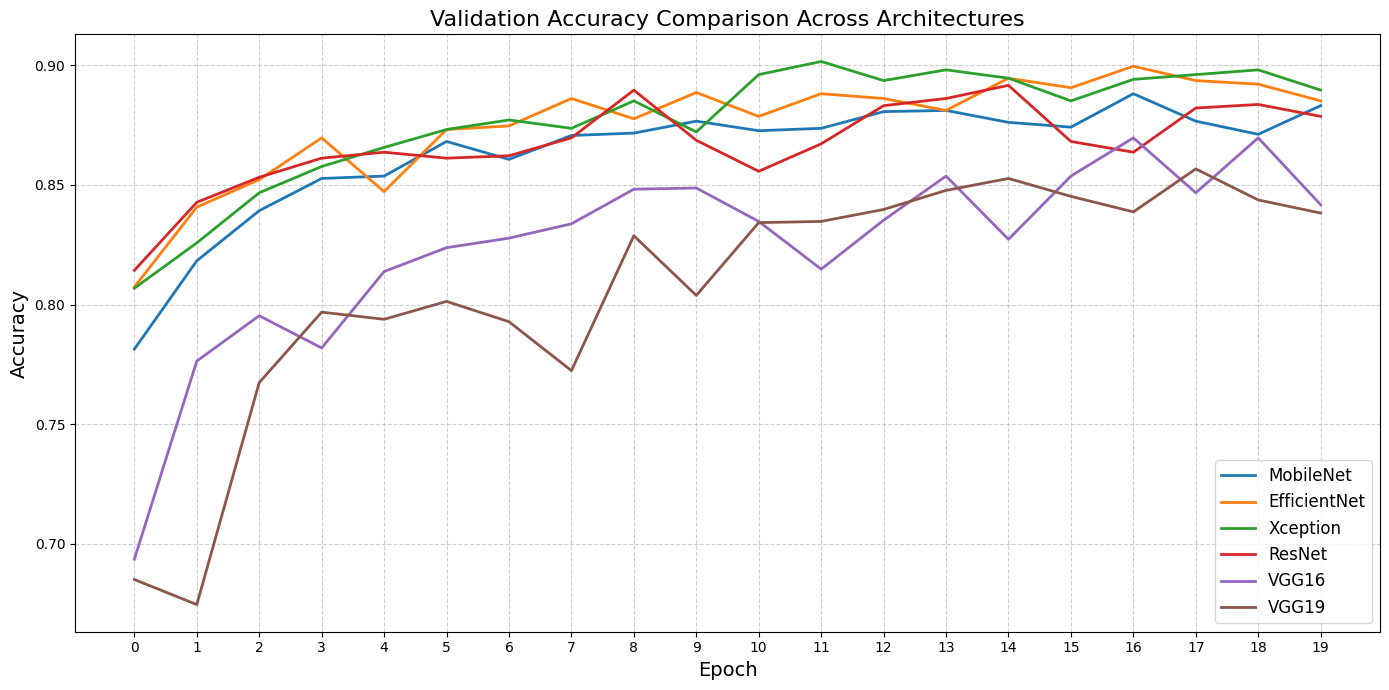

In [13]:
import matplotlib.pyplot as plt

models_hist = {
    "MobileNet": hist_mobilenet,
    "EfficientNet": hist_eff,
    "Xception": hist_xcep,
    "ResNet": hist_res,
    "VGG16": hist_vgg16,
    "VGG19": hist_vgg19
}

plt.figure(figsize=(14, 7))
for name, hist in models_hist.items():
    plt.plot(hist["val_acc"], label=name, linewidth=2)

plt.title("Validation Accuracy Comparison Across Architectures", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.xticks(range(len(next(iter(models_hist.values()))["val_acc"])))
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Gathering Metrics: 100%|██████████| 63/63 [00:12<00:00,  4.95it/s]


<Figure size 1000x800 with 0 Axes>

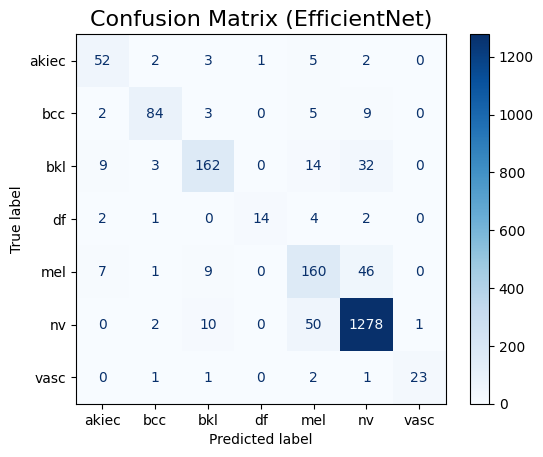

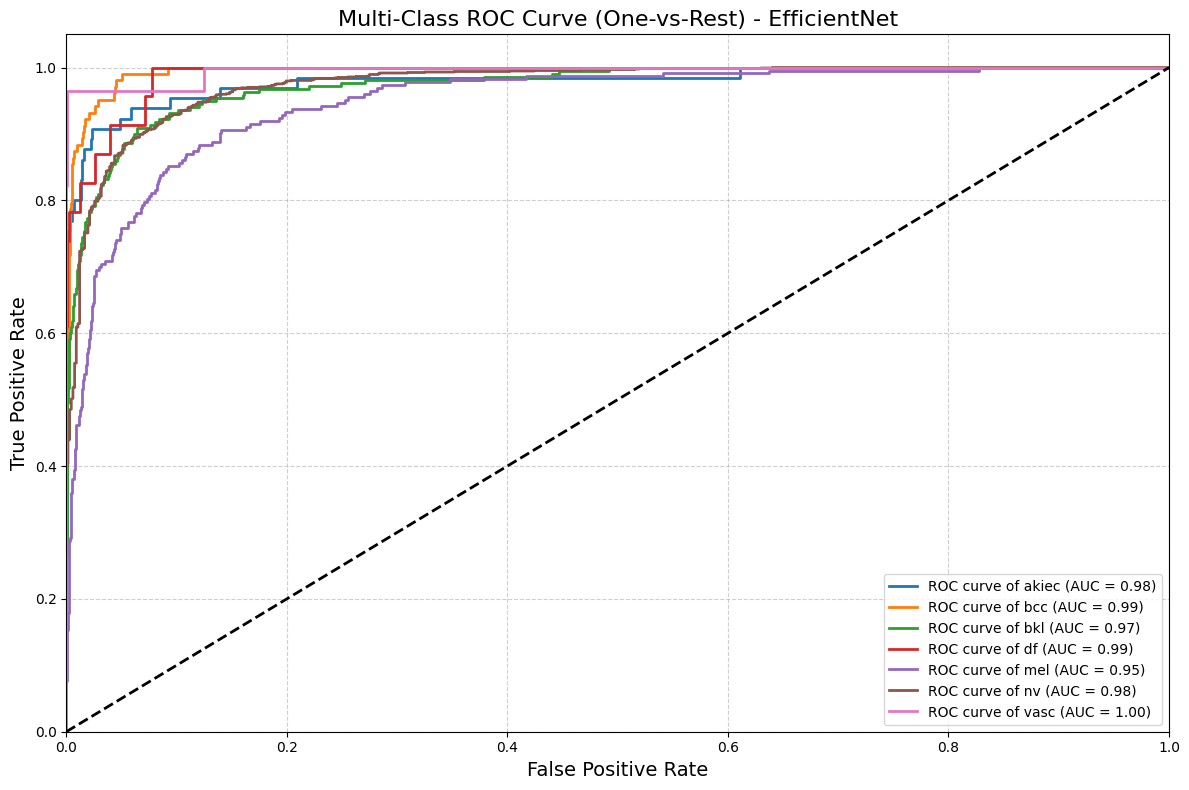

In [14]:
import numpy as np
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import torch.nn.functional as F

# --- 1. GATHER ALL PREDICTIONS ---
# Use the best model (e.g., EfficientNet, based on typical performance)
MODEL_TO_EVALUATE = model_eff

device = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_TO_EVALUATE.to(device).eval()

all_labels = []
all_probs = []
all_preds = []

with torch.no_grad():
    for x, y in tqdm(val_loader, desc="Gathering Metrics"):
        x, y = x.to(device), y.to(device)
        out = MODEL_TO_EVALUATE(x)
        probs = F.softmax(out, dim=1)
        preds = torch.argmax(out, dim=1)

        all_labels.extend(y.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

all_labels = np.array(all_labels)
all_probs = np.array(all_probs)
all_preds = np.array(all_preds)

# --- 2. CONFUSION MATRIX ---
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title(f"Confusion Matrix ({MODEL_TO_EVALUATE.__class__.__name__})", fontsize=16)
plt.show()


# --- 3. ROC-AUC CURVE (One-vs-Rest) ---
plt.figure(figsize=(12, 8))
fpr = {}
tpr = {}
roc_auc = {}

# Compute ROC curve and ROC area for each class
for i in range(num_classes):
    # Get true binary labels (1 if class is i, 0 otherwise)
    y_true_binary = (all_labels == i).astype(int)

    # Get probability for class i
    y_score = all_probs[:, i]

    fpr[i], tpr[i], _ = roc_curve(y_true_binary, y_score)
    roc_auc[i] = auc(fpr[i], tpr[i])

    plt.plot(fpr[i], tpr[i],
             label=f'ROC curve of {idx_to_class[i]} (AUC = {roc_auc[i]:.2f})',
             linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title(f'Multi-Class ROC Curve (One-vs-Rest) - {MODEL_TO_EVALUATE.__class__.__name__}', fontsize=16)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Generating SAM mask (this may take a moment)...


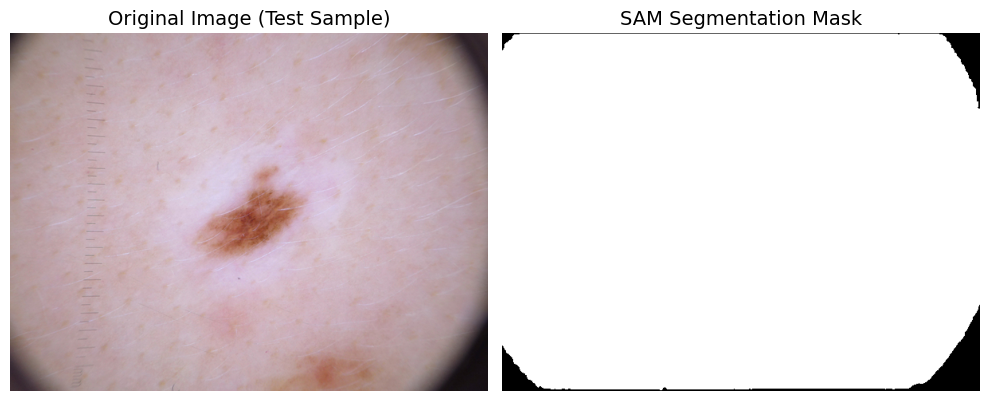

In [16]:
import torch
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

# --- Download SAM Checkpoint (ViT-B is a good balance of speed/accuracy) ---
# Checkpoint URL
CHECKPOINT_URL = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth"
# Local filename
sam_checkpoint = "sam_vit_b_01ec64.pth" # Updated to match the downloaded filename

if not os.path.exists(sam_checkpoint):
    print(f"Downloading SAM checkpoint: {sam_checkpoint}")
    !wget -q {CHECKPOINT_URL}

# --- Setup SAM ---
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

# Initialize device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the model
model_type = "vit_b"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

# --- Automatic Mask Generator ---
# This generator finds all objects. For medical images, we often want high recall.
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=16, # Controls resolution/density of mask points
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100, # Filter out tiny noise regions
)

def sam_segmentation(image: np.ndarray) -> np.ndarray:
    """
    Generates a combined mask of the most relevant segment(s) using SAM.
    The most relevant mask is typically the largest one.
    """
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)

    # SAM expects a BGR image, but Gradio/OpenCV typically use RGB,
    # and the generator can handle the input array directly.
    masks = mask_generator.generate(image)

    if not masks:
        # Return a black image if no masks are found
        return np.zeros_like(image[:,:,0], dtype=np.uint8)

    # Find the largest mask, which is most likely the lesion
    largest_mask = max(masks, key=lambda x: x['area'])['segmentation']

    # Optional: Combine the top N largest masks
    # masks_sorted = sorted(masks, key=lambda x: x['area'], reverse=True)
    # final_mask = np.zeros_like(largest_mask)
    # for i in range(min(len(masks_sorted), 3)): # Combine top 3
    #     final_mask = np.logical_or(final_mask, masks_sorted[i]['segmentation'])

    return (largest_mask * 255).astype(np.uint8)

# --- Visualization Test ---
# Get an image path from the validation set
test_image_id = X_val_ids[0]
test_image_path = val_loader.dataset.id_to_path.get(test_image_id)
img_test = cv2.imread(test_image_path)
img_test = cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB)

print("Generating SAM mask (this may take a moment)...")
sam_mask = sam_segmentation(img_test)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image (Test Sample)", fontsize=14)
plt.imshow(img_test)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("SAM Segmentation Mask", fontsize=14)
plt.imshow(sam_mask, cmap="gray")
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import gradio as gr
import torch.nn.functional as F
import random # Import the random module

# Use the best trained model for the interface
MODEL_FOR_INFERENCE = model_eff
device = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_FOR_INFERENCE.to(device).eval()

def predict(img):
    """Classification prediction function."""
    # Convert PIL image to numpy array for transformations
    img_np = np.array(img)
    # Apply validation transforms, unsqueeze batch dimension, move to device
    img_tensor = val_tfms(image=img_np)["image"].unsqueeze(0).to(device)

    with torch.no_grad():
        out = MODEL_FOR_INFERENCE(img_tensor)
        prob = F.softmax(out, dim=1)[0].cpu().numpy()

    return {idx_to_class[i]: float(prob[i]) for i in range(num_classes)}

def segment(img):
    """Segmentation function using the pre-loaded SAM model."""
    # Convert PIL image to numpy array
    img_np = np.array(img)
    # Call the SAM function defined in the previous cell
    mask_result = sam_segmentation(img_np)

    # Combine mask with original image for better visualization (optional but nice)
    overlay = img_np.copy()
    # Find contours or just use the mask
    overlay[mask_result > 0] = overlay[mask_result > 0] * 0.5 + np.array([255, 0, 0]) * 0.5 # Red overlay

    return overlay

# Get a few examples for the interface
dataset_obj = val_loader.dataset # Use the dataset object to get paths
examples = []
for _ in range(3):
    example_id = random.choice(dataset_obj.img_ids)
    example_path = dataset_obj.id_to_path.get(example_id)
    if example_path:
        examples.append([example_path])

with gr.Blocks(theme=gr.themes.Soft(), title="Skin Cancer AI Diagnosis System") as demo:
    gr.Markdown("# 🧬 Skin Cancer AI Diagnosis System (Paper-Ready Pipeline)")
    gr.Markdown(f"Classification Backbone: **{MODEL_FOR_INFERENCE.__class__.__name__}** | Segmentation Model: **SAM (ViT-B)**")

    with gr.Row():
        with gr.Column(scale=1):
            inp = gr.Image(type="pil", label="Upload Skin Image", height=250)
            btn1 = gr.Button("Classify", variant="primary")
            btn2 = gr.Button("Segment (SAM)", variant="secondary")

        with gr.Column(scale=2):
            out1 = gr.Label(num_top_classes=num_classes, label="Classification Prediction")
            out2 = gr.Image(label="SAM Segmentation Overlay (Red = Lesion Mask)", height=250)

    gr.Examples(
        examples=examples,
        inputs=inp,
        label="Example Images from Validation Set"
    )

    btn1.click(predict, inp, out1)
    btn2.click(segment, inp, out2)

print("Launching Gradio Interface...")
demo.launch(debug=True, share=True)

/tmp/ipython-input-2488987446.py:46: DeprecationWarning: The 'theme' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'theme' to Blocks.launch() instead.
  with gr.Blocks(theme=gr.themes.Soft(), title="Skin Cancer AI Diagnosis System") as demo:


Launching Gradio Interface...
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://2beaa7645521f4b3ac.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
